# Computing Hake NASC from the Pacific Hake Survey

Jupyter notebook accompanying the manuscript:

_Echopype: A Python library for interoperable and scalable processing of ocean sonar data for biological information_   
_Authors: Wu-Jung Lee, Emilio Mayorga, Landung Setiawan, Kavin Nguyen, Imran Majeed, Valentina Staneva, Caesar Tuguinay_

## Introduction

### Description

This notebook uses a subset of the EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey ('Pacific Hake Survey')](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate a common workflow for data conversion, calibration, regridding, and masking using [`echopype`](https://echopype.readthedocs.io), [`echoregions`](https://echoregions.readthedocs.io), and core scientific Python software packages (particularly `xarray`, `Dask` and `NumPy`) to compute Hake attributed Nautical Areal Scattering Coefficient (NASC). This workflow utilizes Echoregions' compatibility with Echopype data products to incorporate ocean bottom annotations and Hake annotations with backscatter measurements.

### Outline

1) Convert EK60 RAW Files to Echodata Objects
2) Combine Echodata Objects
3) Calibrate Combined Echodata Object
4) Regrid and Plot Calibrated Data
5) Compute and Plot Transect Mask
6) Compute and Plot Hake Mask
7) Compute and Plot Bottom Mask
8) Apply all 3 Masks on the MVBS dataset and Plot the Masked MVBS
9) Compute and Plot Hake NASC

### Running the notebook

This notebook can be run with a conda environment created using the conda environment file https://github.com/OSOceanAcoustics/echopype-examples/blob/main/binder/environment.yml. The notebook creates a directory, if not already present: `./exports/hake_notebook_outputs`. Zarr files will be exported there.

### Note
We encourage importing `echopype` as `ep` for consistency.

In [1]:
from pathlib import Path
import os

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client

import echopype as ep
from echopype import colormap # noqa
import echoregions as er

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# Ignore large graph dask UserWarnings
warnings.simplefilter("ignore", category=UserWarning)

Set paths and create directories to store Zarr files:

In [2]:
import_path = Path('example_data/NWFSC_2017_hake_survey_transect_with_hake/')

output_dpath = Path('./exports/hake_notebook_outputs')
output_dpath.mkdir(exist_ok=True, parents=True)

echodata_zarr_path = Path(output_dpath / 'hake_survey_echodata_zarr')
echodata_zarr_path.mkdir(exist_ok=True)
combined_zarr_path = Path(output_dpath / 'combined_zarr')
combined_zarr_path.mkdir(exist_ok=True)

Grab RAW EK60 files associated with the first segment of the 45th transect:

In [3]:
ncei_2017_ek60_raws_path = "ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60"
transect_name = "x0045_0_wt_20170717_213507_f0010"
transect_file_paths = []
with open(import_path / transect_name, 'r') as file:
    for line in file:
        transect_file_paths.append(
            f"{ncei_2017_ek60_raws_path}/{line.strip()}.raw"
        )

In [4]:
transect_file_paths

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T212115.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T214833.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T221909.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T224632.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T231028.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T233247.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T235306.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T001206.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T003054.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T004846.raw']

### Dask Client Setup

Echopype uses Dask in the background to lazily load, do out-of-memory and parallelized computation on large arrays. Dask Client helps schedule tasks and allocate memory for these large array computations.

In [5]:
# Use maximum number of CPUs for Dask Client
client = Client(n_workers=os.cpu_count())
print("Dash Client Dashboard:", client.dashboard_link)

Dash Client Dashboard: http://127.0.0.1:8787/status


The following Echopype processing code follows a pattern of `to_zarr` and "open zarr" for the more computationally challenging processing stages. This patterns points computation outputs to be stored in disk instead of in memory, and when this computation is done, it lazily-loads the recently computed arrays.

### Convert EK60 RAW Files to Echodata Objects

In [6]:
%%time

# Save Echodata objects locally
def open_and_save(raw_file, sonar_model, use_swap, save_path, storage_options):
    try:
        ed = ep.open_raw(
            raw_file=f's3://{raw_file}',
            sonar_model=sonar_model,
            use_swap=use_swap,
            storage_options=storage_options,
        )
        ed.to_zarr(save_path, overwrite=True, compute=True)
    except Exception as e:
        print("Error with Exception: ", e)

# Parse EK60 `.RAW` file and save to Zarr Store
open_and_save_futures = []
for raw_file_url in transect_file_paths:
    open_and_save_future = client.submit(
        open_and_save,
        raw_file=raw_file_url,
        sonar_model='ek60',
        use_swap=True,
        save_path=echodata_zarr_path,
        storage_options={'anon': True}
    )
    open_and_save_futures.append(open_and_save_future)
open_and_save_futures = client.gather(open_and_save_futures)

CPU times: user 2.06 s, sys: 388 ms, total: 2.44 s
Wall time: 7.65 s


###  Combine Echodata Objects

In [7]:
%%time

# Open Zarr Stores containing Echodata Objects, Lazy Load them, and Lazily Combine Echodata Objects
ed_future_list = []
for converted_file in sorted(echodata_zarr_path.glob("*.zarr")):
    ed_future = client.submit(    
        ep.open_converted,
        converted_raw_path=converted_file,
        chunks={}
    )
    ed_future_list.append(ed_future)
ed_list = client.gather(ed_future_list)
ed_combined = ep.combine_echodata(ed_list)

# Save to Zarr and offload computation to disk
ed_combined.to_zarr(
    combined_zarr_path / "ed_combined.zarr",
    overwrite=True,
    compute=True,
)

# Lazily Open Zarr
ed_combined = ep.open_converted(
    combined_zarr_path / "ed_combined.zarr",
    chunks={},
)

CPU times: user 13.9 s, sys: 1.59 s, total: 15.5 s
Wall time: 19.2 s


### Calibrate Combined Echodata Object

Compute Mean Volume Backscattering Strength (MVBS). This gets our data into a 'commongrid' format where each point in the 'Echogram' covers the same ping time length and depth height as every other point.

In [8]:
%%time

# Chunk Echodata Object ping-wise
ed_combined = ed_combined.chunk({"ping_time": 1000})

# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(ed_combined)

# Add Depth
ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=9.15)

# Add Latitude and Longitude
ds_Sv = ep.consolidate.add_location(ds_Sv, ed_combined)

# Save to Zarr and offload computation to disk
ds_Sv.to_zarr(
    combined_zarr_path / "ds_Sv.zarr",
    mode="w",
    compute=True,
)

# Lazily Open Zarr
ds_Sv = xr.open_dataset(
    combined_zarr_path / "ds_Sv.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 1.83 s, sys: 216 ms, total: 2.04 s
Wall time: 2.7 s


### Regrid and Plot Calibrated Data

In [9]:
%%time

# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin='1m',  # in meters
    ping_time_bin='5s',  # in seconds
)

# Save to Zarr and offload computation to disk
ds_MVBS.to_zarr(
    combined_zarr_path / "ds_MVBS.zarr",
    mode="w",
    compute=True,
)

# Lazily Open Zarr
ds_MVBS = xr.open_dataset(
    combined_zarr_path / "ds_MVBS.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 4.91 s, sys: 617 ms, total: 5.52 s
Wall time: 12.2 s


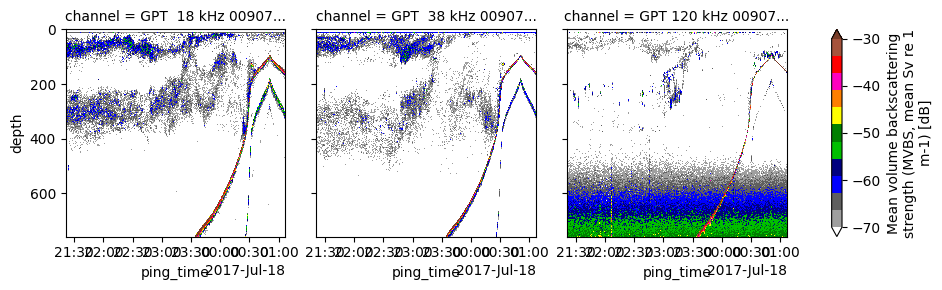

In [10]:
# Plot the all frequency channels of the MVBS dataset
ds_MVBS["Sv"].plot.pcolormesh(
    col="channel",
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500",
)

### Create and Plot Transect Mask

In [11]:
# Parse Echoview Regions File
regions2d = er.read_evr(import_path / "x0045_regions.evr")

Creating the Transect Mask using Echoregions is currently specific to the convention used by NOAA Northwest Fisheries Sciences for their Pacific Hake Survey. For usage of `transect_mask` outside of this survey, the user must denote their ow start, break, resume, and end transect key value pairs described in this docstring: https://github.com/OSOceanAcoustics/echoregions/blob/main/echoregions/regions2d/regions2d.py#L716.

If you have a different schema for transect logging, we encourage you to contribute to the project by creating an issue at https://github.com/OSOceanAcoustics/echoregions/issues where you can propose adding support for your custom schema.

In [12]:
# Create Transect Mask
transect_mask_da = regions2d.transect_mask(ds_MVBS["Sv"])

The transect mask will have 'within transect' encoded as 1 and 'outside transect' encoded as 0.

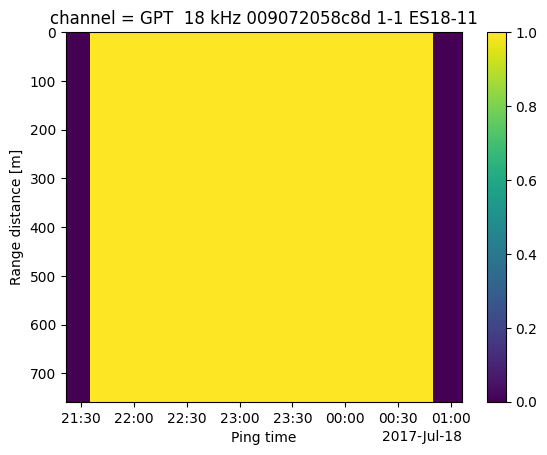

In [13]:
# Plot Transect Mask
transect_mask_da.plot(y="depth", yincrease=False)

Encode 'Within Transect' as True, and 'Outside Transect' as False to use downstream as a boolean mask:

In [15]:
# Turn mask with integer values to boolean mask
transect_boolean_mask_da = transect_mask_da.astype(bool).transpose(
    "ping_time", "depth"
)

### Create and Plot Hake Mask

For more information on Masking Regions using Echoregions and the underlying class' functionality, please see: https://echoregions.readthedocs.io/en/latest/Regions2D_functionality.html

In [16]:
# Grab Hake Regions
hake_regions = regions2d.select_region(region_class="Hake")

In [91]:
# Show Hake Regions
hake_regions

,file_name,file_type,evr_file_format_number,echoview_version,region_id,region_structure_version,region_point_count,region_selected,region_creation_type,dummy,...,region_bbox_right,region_bbox_top,region_bbox_bottom,region_class,region_type,region_name,time,depth,region_notes,region_detection_settings
16,x0045_regions.evr,EVRG,7,13.0.378.44817,31,13,10,0,2,-1,...,2017-07-18 00:32:38.498500,165.528208,368.620818,Hake,1,H23U-Region31,"[2017-07-18T00:32:38.498500000, 2017-07-18T00:...","[186.0156202136, 174.8811569187, 165.528207751...",[AWT 23 on line 48],[]
17,x0045_regions.evr,EVRG,7,13.0.378.44817,32,13,76,0,2,-1,...,2017-07-17 22:56:03.693500,315.639445,437.42681,Hake,1,H22U-Region32,"[2017-07-17T22:21:22.711000000, 2017-07-17T22:...","[353.1124807396, 353.1124807396, 337.889060092...","[LCH: Agreed., , JG: This looks like the sig...",[]


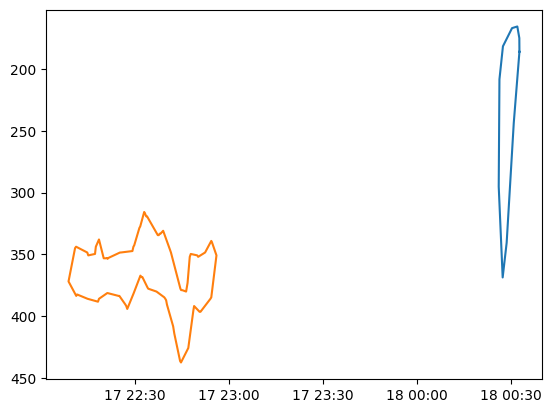

In [18]:
# Plot Closed Hake Regions
hake_regions_closed = regions2d.close_region(region_class="Hake")
for _, row in hake_regions_closed.iterrows():
    plt.plot(row["time"], row["depth"])
plt.gca().invert_yaxis()
plt.show()

Plotting the Hake Regions on top of the 38 kHz frequency Echogram:

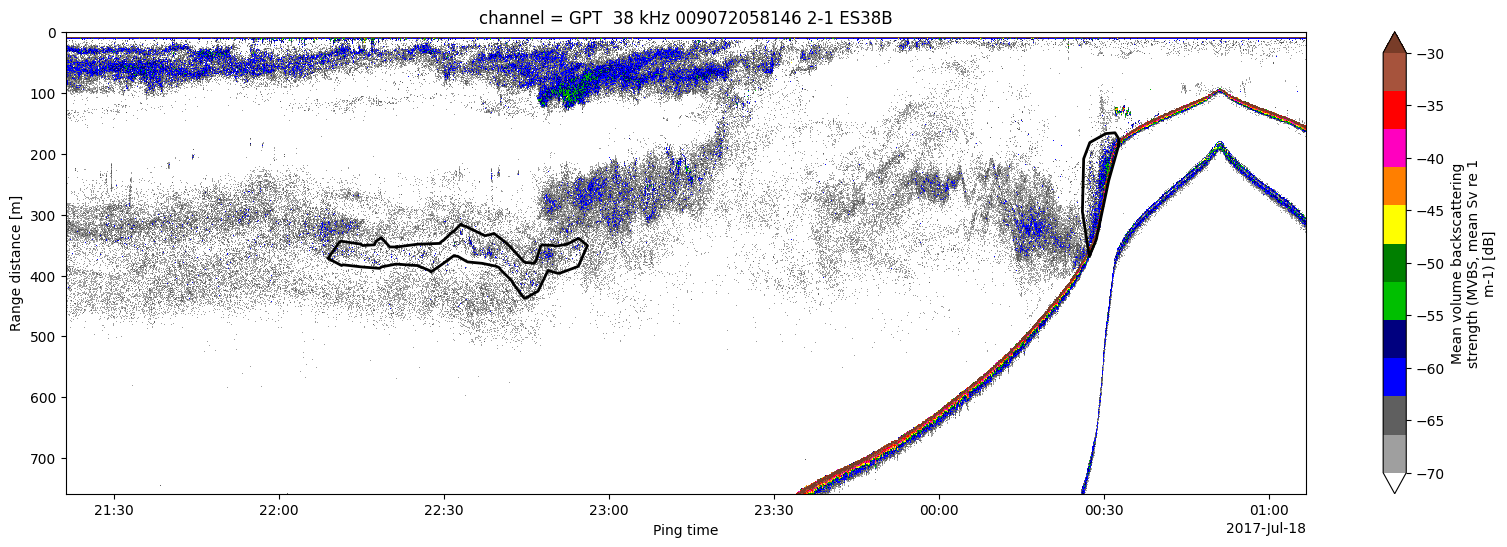

In [102]:
# Plotting the echogram with the hake regions
plt.figure(figsize=(20, 6))
for _, point in hake_regions_closed.iterrows():
    plt.plot(
        point["time"],
        point["depth"],
        fillstyle='full',
        linewidth=2,
        markersize=1,
        color="black",
    )
ds_MVBS["Sv"].isel(channel=1).T.plot(
    y="depth",
    yincrease=False,
    vmin=-70, vmax=-30,
    cmap="ep.ek500"
)

In [20]:
# Use the built in mask function to create a mask
hake_mask_ds, hake_region_points = regions2d.region_mask(
    ds_MVBS["Sv"].isel(channel=0).drop_vars("channel").compute(),
    region_class="Hake",
    collapse_to_2d=True,
)

The 2D Hake Mask will encode background as NaN, and the Hake Regions as their respective region_id values.

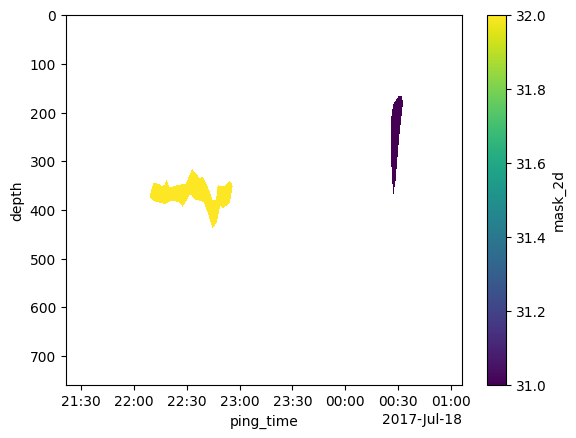

In [21]:
# Plot Hake Regions
hake_mask_ds["mask_2d"].plot(y="depth", yincrease=False)

Encode Hake as True, and Non-Hake as False to use downstream as a boolean mask:

In [36]:
# Turn mask with integer values to boolean mask
hake_boolean_mask_da = xr.where(
    hake_mask_ds["mask_2d"] > 0, True, False
).transpose("ping_time", "depth")

### Create and Plot Bottom Mask

For more information on Masking Bottom using Echoregions and the underlying class' functionality, please see: https://echoregions.readthedocs.io/en/latest/Lines_functionality.html

In [23]:
# Parse Echoview Lines File
lines = er.read_evl(import_path / "x0045_lines.evl")

# Grab lines dataframe
lines_df = lines.data

In [60]:
# Show lines data
lines_df.head(3)

,file_name,file_type,evl_file_format_version,echoview_version,time,depth,status
0,x0045_lines.evl,EVBD,3,13.0.378.44817,2017-01-20 11:27:37.034000,17.518239,3
1,x0045_lines.evl,EVBD,3,13.0.378.44817,2017-01-20 11:27:38.044000,16.886161,3
2,x0045_lines.evl,EVBD,3,13.0.378.44817,2017-01-20 11:27:39.055000,16.537958,3


Note the rightmost column status. Status values are generally described by the following:

0 = none

1 = unverified

2 = bad

3 = good

The good and bad values are assigned via the specific EVL line picking formula used to generate the initial EVL file. Generally, we only want the rows with good/3 status.

More information on Echoview Status can be found here: [Line Status](https://support.echoview.com/WebHelp/Using_Echoview/Echogram/Lines/About_Line_Status.htm).

In [24]:
# Get only 'good' bottom points
good_lines_df = lines_df[lines_df['status'] == '3']
good_bottom = good_lines_df[['time', 'depth']]
lines.data = good_lines_df

Plotting the Bottom on top of the 38 kHz frequency Echogram:

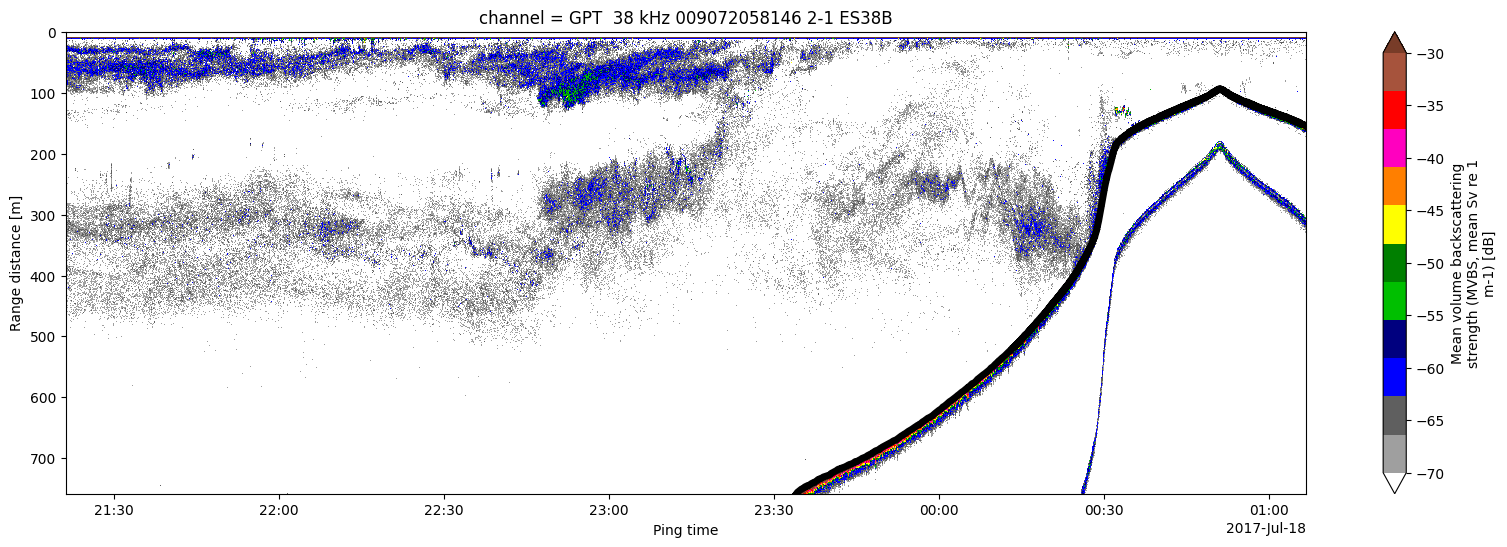

In [25]:
# Plotting the Echogram data and the bottom
plt.figure(figsize = (20, 6))
plt.plot(
    lines.data['time'],
    lines.data['depth'],
    'black',
    fillstyle='full',
    linewidth=5,
    markersize=1,
)
ds_MVBS["Sv"].isel(channel=1).T.plot.pcolormesh(
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500",
)

We can then create a mask for the bottom using the same algorithm Echoview uses:

In [26]:
# Use the built in mask function
bottom_mask_da, bottom_points = lines.bottom_mask(
    ds_MVBS["Sv"].isel(channel=0).drop_vars("channel").compute(),
    operation="above_below",
    method="slinear",
    limit_area=None,
    limit_direction="both"
)

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


The Bottom Mask will encode background as 0 and the Bottom as 1:

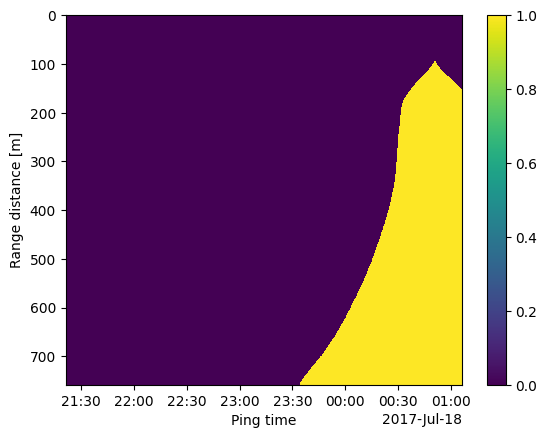

In [27]:
# Plotting the bottom mask
bottom_mask_da.plot(y="depth", yincrease=False)

Encode Bottom as True, and Non-Bottom as False to use downstream as a boolean mask:

In [28]:
# Turn mask with integer values to boolean mask
bottom_boolean_mask_da = bottom_mask_da.astype(bool).transpose("ping_time", "depth")

### Apply all 3 Masks on the MVBS dataset and Plot the Masked MVBS

**Note**: The reason we have converted all our masks into boolean masks is because, under the hood, `apply_mask` performs a logical AND element-wise operation across the list of masks to create 1 mask, which it then applies on the MVBS dataset.

In [94]:
# Apply the three masks on MVBS
ds_MVBS_transect_cleaned_hake = ep.mask.apply_mask(
    ds_MVBS,
    [
        hake_boolean_mask_da,
        ~bottom_boolean_mask_da, # Negate since we don't want bottom
        transect_boolean_mask_da,
    ]
)

We plot the 38 kHz channel here since this is what is used for downstream biomass estimation:

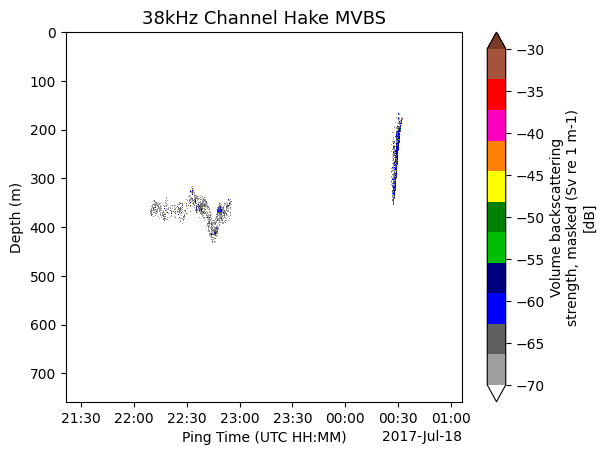

In [101]:
# Add attributes to depth and ping time
ds_MVBS_transect_cleaned_hake["depth"].attrs["long_name"] = "Depth (m)"
ds_MVBS_transect_cleaned_hake["ping_time"].attrs["long_name"] = "Ping Time (UTC HH:MM)"

# Plot 38 kHz MVBS attributed to Clean Hake
p = ds_MVBS_transect_cleaned_hake["Sv"].sel(
    channel='GPT  38 kHz 009072058146 2-1 ES38B'
).plot.pcolormesh(
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500"
)


# Set axes title
p.axes.set_title("38kHz Channel Hake MVBS", fontsize=13)

# Show plot
plt.show()

### Compute and Plot Hake NASC

In [46]:
# Compute NASC on clean hake masked MVBS
hake_NASC = ep.commongrid.compute_NASC(
    ds_MVBS_transect_cleaned_hake,
    range_bin="10m",
    dist_bin="0.5nmi"
)

# Compute decibel NASC using elementwise operations and add long name attribute
hake_NASC["dB_NASC"] = 10 * np.log10(hake_NASC["NASC"])
hake_NASC["dB_NASC"].attrs = {
    "long_name": "Decibel Nautical Areal Scattering Coefficient (dB-NASC)",
    "units": "dB m2 nmi-2"
}

In [56]:
# Show Hake NASC dataset
hake_NASC

<xarray.Dataset> Size: 295kB
Dimensions:            (channel: 3, distance: 80, depth: 76)
Coordinates:
  * distance           (distance) float64 640B 0.0 0.5 1.0 ... 38.5 39.0 39.5
  * channel            (channel) <U37 444B 'GPT  18 kHz 009072058c8d 1-1 ES18...
  * depth              (depth) float64 608B 0.0 10.0 20.0 ... 730.0 740.0 750.0
Data variables:
    NASC               (channel, distance, depth) float64 146kB dask.array<chunksize=(3, 80, 76), meta=np.ndarray>
    latitude           (distance) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
    longitude          (distance) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
    ping_time          (distance) datetime64[ns] 640B 2017-07-17T21:23:27.500...
    frequency_nominal  (channel) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    dB_NASC            (channel, distance, depth) float64 146kB dask.array<chunksize=(3, 80, 76), meta=np.ndarray>
Attributes:
    Conventions:           CF-1.7,ACDD-1.3
    time_coverage_start:   2017-07-17T21:21:15.000000000Z
    time_coverage_end:     2017-07-18T01:06:35.000000000Z
    geospatial_lat_min:    41.79633
    geospatial_lat_max:    41.82402
    geospatial_lon_min:    -125.21041
    geospatial_lon_max:    -124.41516
    processing_level:      Level 4
    processing_level_url:  https://echopype.readthedocs.io/en/stable/processi...

We use a dB scale to visualize the wide range of values in NASC:

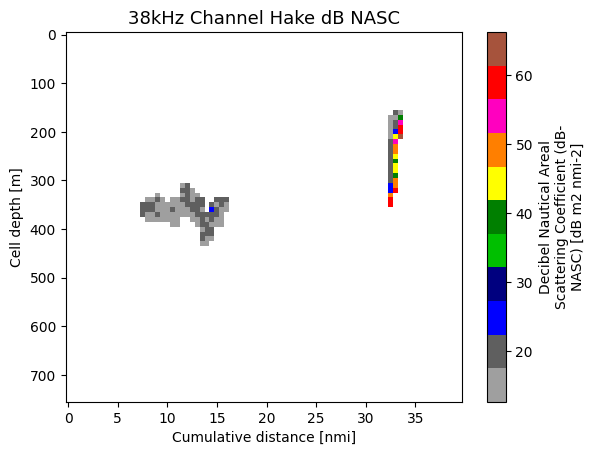

In [103]:
# Plot 38 kHz Hake dB NASC
p = hake_NASC["dB_NASC"].sel(
    channel='GPT  38 kHz 009072058146 2-1 ES38B'
).plot.pcolormesh(
    y="depth",
    yincrease=False,
    cmap="ep.ek500"
)

# Set axes title
p.axes.set_title("38kHz Channel Hake dB NASC", fontsize=13)

# Show plot
plt.show()